##### Copyright 2022 The Cirq Developers

In [1]:
# @title Licensed under the Apache License, Version 2.0 (the "License");
# you may not use this file except in compliance with the License.
# You may obtain a copy of the License at
#
# https://www.apache.org/licenses/LICENSE-2.0
#
# Unless required by applicable law or agreed to in writing, software
# distributed under the License is distributed on an "AS IS" BASIS,
# WITHOUT WARRANTIES OR CONDITIONS OF ANY KIND, either express or implied.
# See the License for the specific language governing permissions and
# limitations under the License.

# Coherent vs Incoherent Error with XEB

<table class="tfo-notebook-buttons" align="left">
  <td>
    <a target="_blank" href="https://quantumai.google/cirq/noise/qcvv/coherent_vs_incoherent_xeb>"><img src="https://quantumai.google/site-assets/images/buttons/quantumai_logo_1x.png" />View on QuantumAI</a>
  </td>
  <td>
    <a target="_blank" href="https://colab.research.google.com/github/quantumlib/Cirq/blob/main/docs/noise/qcvv/coherent_vs_incoherent_xeb.ipynb"><img src="https://quantumai.google/site-assets/images/buttons/colab_logo_1x.png" />Run in Google Colab</a>
  </td>
  <td>
    <a target="_blank" href="https://github.com/quantumlib/Cirq/blob/main/docs/noise/qcvv/coherent_vs_incoherent_xeb.ipynb"><img src="https://quantumai.google/site-assets/images/buttons/github_logo_1x.png" />View source on GitHub</a>
  </td>
  <td>
    <a href="https://storage.googleapis.com/tensorflow_docs/Cirq/docs/noise/qcvv/coherent_vs_incoherent_xeb.ipynb"><img src="https://quantumai.google/site-assets/images/buttons/download_icon_1x.png" />Download notebook</a>
  </td>
</table>

This notebook demonstrates how to use Cross Entropy Benchmarking (XEB) end-to-end to compare coherent gate parameter error and incoherent depolarization error. It will mimic a small device graph of `cirq.GridQubit` pairs and simulate two-qubit XEB benchmarking circuits on them with noise models that introduce coherent and incoherent error before visualizing and comparing the results.

For more information on types of error, see [Average, Pauli and Incoherent Error](../../google/calibration.md#average-pauli-and-incoherent_error). 

For more information on noise and noise models, see [Noise](../).

For more information on how XEB works in detail, see [XEB Theory](./xeb_theory.ipynb) notebook.

## Setup

In [2]:
try:
    import cirq
except ImportError:
    print("installing cirq...")
    !pip install --quiet cirq
    print("installed cirq.")
    import cirq

import numpy as np

installing cirq...


ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
tensorflow-metadata 1.16.1 requires protobuf<4.21,>=3.20.3; python_version < "3.11", but you have protobuf 4.25.5 which is incompatible.


installed cirq.


## Generate Random Circuits

First create a circuit library of 20 random, two-qubit circuits which uses `cirq.SQRT_ISWAP` as the entangling two-qubit gate, using `cirq.experiments.random_quantum_circuit_generation.generate_library_of_2q_circuits
`.

In [3]:
from cirq.experiments import random_quantum_circuit_generation as rqcg

RANDOM_SEED = np.random.RandomState(53)

circuit_library = rqcg.generate_library_of_2q_circuits(
    n_library_circuits=20, two_qubit_gate=cirq.SQRT_ISWAP, random_state=RANDOM_SEED
)
max_depth = 100
cycle_depths = np.arange(3, max_depth, 20)

## Prepare Noise Models

To compare coherent and incoherent error, use two different noise models, which introduce coherent and incoherent error respectively. Also included are a noiseless model and a "fused" model that combines both coherent and incoherent error, for comparison. See [Noise](../) for the difference between coherent and incoherent error. 

The coherent noise model is represented by a perturbed `SQRT_ISWAP` gate, which implements a slightly different unitary than a true `SQRT_ISWAP`. Perturbed gates are caused by hardware losing its calibrated tuning, which typically occurres naturally over time between device calibrations. 

The incoherent noise model to be compared with is a `cirq.DepolarizingChannel`, representing a low chance (`5e-3`) for the state of each qubit to depolarize after an operation is performed on it, as if a random Pauli operator was applied to it.

An noiseless sampler simply has no noise. 

Finally, the `fused_sampler` adds both coherent and incoherent error to each moment of the circuit, applied in order, according to the `noisy_moment` function of the `FusedNoiseModel` class. It uses the same noise models as the coherent-only and incoherent-only models, perturbation and depolarization, but applies both in sequence. 

Start by creating the necessary elements to create the coherent and fused samplers. The following code shows how `SQRT_ISWAP` can be written as a specific `cirq.PhasedFSimGate`.

In [4]:
# build sqrt_iswap gate from a phased fsim gate
sqrt_iswap_as_phased_fsim = cirq.PhasedFSimGate.from_fsim_rz(
    theta=-np.pi / 4, phi=0, rz_angles_before=(0, 0), rz_angles_after=(0, 0)
)

# check that the unitaries are the same
np.testing.assert_allclose(
    cirq.unitary(sqrt_iswap_as_phased_fsim), cirq.unitary(cirq.SQRT_ISWAP), atol=1e-8
)

Next, create a perturbed version of `SQRT_ISWAP`. Note the phi angle uniformly chosen in the range $[0, 2/16*\pi]$, which was previously `0`. Additionally, create the gate substitution function, `_sub_iswap`, which replaces `SQRT_ISWAP` gates in the simulated circuit with the perturbed version.

In [5]:
from collections import defaultdict

phi_angles = defaultdict(lambda: RANDOM_SEED.uniform(low=0, high=2 / 16 * np.pi))


def _sub_iswap(op):
    if op.gate == cirq.SQRT_ISWAP:
        # add coherent error to the phi angle while creating a sqrt iswap gate
        perturbed_sqrt_iswap = cirq.PhasedFSimGate.from_fsim_rz(
            theta=-np.pi / 4,
            phi=phi_angles[op.qubits],
            rz_angles_before=(0, 0),
            rz_angles_after=(0, 0),
        )

        return perturbed_sqrt_iswap.on(*op.qubits)
    return op

For the "fused" model, create a `FusedNoiseModel` class, which applies multiple noise models in sequence to each moment. This will create a noise model which incorporates both coherent and incoherent noise. 

In [6]:
from typing import Sequence


class FusedNoiseModel(cirq.NoiseModel):
    """A noise model that applies other noise models in sequence"""

    def __init__(self, models: Sequence[cirq.NoiseModel]):
        self.models = models

    def noisy_moment(self, moment: 'cirq.Moment', system_qubits: Sequence['cirq.Qid']):
        """Produce a list of moments by applying each model in sequence to the available moments"""

        moments = [moment]
        for model in self.models:
            new_moments = []
            for moment in moments:
                ret = model.noisy_moment(moment, system_qubits)
                # handle constituent noise models returning lists of or singleton moments
                new_moments.extend([ret] if isinstance(ret, cirq.Moment) else ret)
            moments = new_moments
        return moments

Finally, initialize the noise model objects: 

1. For coherent error, use the `_sub_iswap` function to create a `cirq.GateSubstitutionNoiseModel`, which replaces the `SQRT_ISWAP` gate with the perturbed version. 

2. For incoherent error, create a `cirq.ConstantQubitNoiseModel` which depolarizes every qubit in the same way. 

3. The noiseless sampler will have a noise of `None`.

4. Build the fused noise model with the other two from the `FusedNoiseModel` class, applying each constituent noise model in sequence.

... and create the samplers with `cirq.DensityMatrixSimulator` for each noise model. 

In [7]:
# create noise models
coherent_noise = cirq.devices.noise_model.GateSubstitutionNoiseModel(_sub_iswap)
incoherent_noise = cirq.ConstantQubitNoiseModel(cirq.depolarize(5e-3))
noiseless = None
fused_noise = FusedNoiseModel([coherent_noise, incoherent_noise])

# create samplers by passing noise models to simulator constructor
coherent_sampler = cirq.DensityMatrixSimulator(noise=coherent_noise)
incoherent_sampler = cirq.DensityMatrixSimulator(noise=incoherent_noise)
noiseless_sampler = cirq.DensityMatrixSimulator(noise=noiseless)
fused_sampler = cirq.DensityMatrixSimulator(noise=fused_noise)

# from here on out, all experiment steps will be performed on
#   samplers and their results in the following order.
samplers = [coherent_sampler, incoherent_sampler, noiseless_sampler, fused_sampler]
noise_titles = ['Coherent', 'Incoherent', 'Noiseless', 'Fused']

## Mock a device topology

In order to more closely mimic XEB on real hardware, create a graph of qubits to mimic a small device from a couple `cirq.GridQubit`s. XEB benchmark circuits will be created to test multiple qubit pairs simultaneously on this graph, without overlap. 

In this example, only five of the six created qubits are used in order to produce an irregular/non-rectangular graph, and simplify simulation by using fewer qubits.

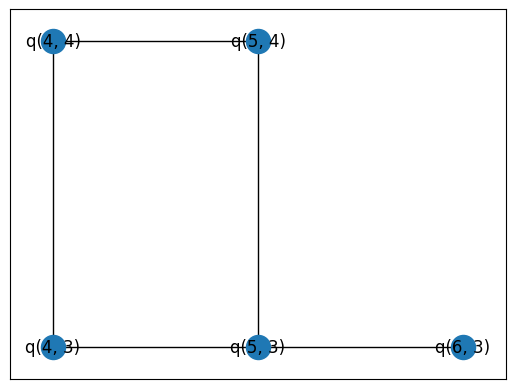

In [8]:
import networkx as nx
import itertools

# a set of six example GridQubits
qubits = cirq.GridQubit.rect(3, 2, 4, 3)
# only use the first num_qubits many qubits
num_qubits = 5
qubits = qubits[:num_qubits]

# create graph from adjacent qubits
graph = nx.Graph((q1, q2) for (q1, q2) in itertools.combinations(qubits, 2) if q1.is_adjacent(q2))
pos = {q: (q.row, q.col) for q in qubits}
nx.draw_networkx(graph, pos=pos)

Set up the active qubit pair combinations for the sampler function.

In [9]:
combs_by_layer = rqcg.get_random_combinations_for_device(
    n_library_circuits=len(circuit_library),
    n_combinations=10,
    device_graph=graph,
    random_state=RANDOM_SEED,
)

## Fidelity Data Collection
### Sample Circuits

The following call will zip together the `circuit_library` circuits according to `combs_by_layer` into larger circuits that evaluate multiple qubit pairs in parallel, before sampling them. Remember that `samplers` contains coherent and incoherent noise samplers, an errorless sampler, and a fused sampler. Mapping `sample_2q_xeb_circuits` to the list of samplers produces sampled data, generated with identical parameters except for the difference in noise model. 

In [10]:
import cirq.experiments.xeb_sampling as xeb_sampling
import cirq.experiments.xeb_fitting as xeb_fitting

# use the same circuit library, cycle depths, combinations by layer,
#   random seed and repetitions for both noise models' samplers.
def sample_df(sampler):
    return xeb_sampling.sample_2q_xeb_circuits(
        sampler=sampler,
        circuits=circuit_library,
        cycle_depths=cycle_depths,
        combinations_by_layer=combs_by_layer,
        shuffle=RANDOM_SEED,
        repetitions=1000,
    )


sampled_dfs = list(map(sample_df, samplers))

  0%|          | 0/207 [00:00<?, ?it/s]

  4%|▍         | 9/207 [00:01<00:28,  7.01it/s]

  9%|▊         | 18/207 [00:01<00:19,  9.58it/s]

 13%|█▎        | 27/207 [00:03<00:20,  8.58it/s]

 17%|█▋        | 36/207 [00:03<00:14, 11.89it/s]

 22%|██▏       | 45/207 [00:04<00:14, 11.34it/s]

 26%|██▌       | 54/207 [00:04<00:11, 12.92it/s]

 30%|███       | 63/207 [00:06<00:14,  9.99it/s]

 35%|███▍      | 72/207 [00:06<00:09, 13.90it/s]

 39%|███▉      | 81/207 [00:07<00:13,  9.38it/s]

 43%|████▎     | 90/207 [00:08<00:10, 11.63it/s]

 48%|████▊     | 99/207 [00:09<00:09, 11.57it/s]

 52%|█████▏    | 108/207 [00:10<00:09, 10.23it/s]

 57%|█████▋    | 117/207 [00:10<00:08, 10.92it/s]

 61%|██████    | 126/207 [00:11<00:07, 10.74it/s]

 65%|██████▌   | 135/207 [00:12<00:05, 13.28it/s]

 70%|██████▉   | 144/207 [00:13<00:05, 10.61it/s]

 74%|███████▍  | 153/207 [00:13<00:04, 13.35it/s]

 78%|███████▊  | 162/207 [00:14<00:03, 12.73it/s]

 83%|████████▎ | 171/207 [00:14<00:02, 13.61it/s]

 87%|████████▋ | 180/207 [00:15<00:02, 12.53it/s]

 91%|█████████▏| 189/207 [00:16<00:01, 12.12it/s]

 96%|█████████▌| 198/207 [00:16<00:00, 14.96it/s]

100%|██████████| 207/207 [00:16<00:00, 19.03it/s]

100%|██████████| 207/207 [00:16<00:00, 12.18it/s]

  0%|          | 0/207 [00:00<?, ?it/s]

  4%|▍         | 9/207 [00:03<01:15,  2.61it/s]

  9%|▊         | 18/207 [00:04<00:39,  4.74it/s]

 13%|█▎        | 27/207 [00:08<01:01,  2.95it/s]

 17%|█▋        | 36/207 [00:09<00:42,  4.03it/s]

 22%|██▏       | 45/207 [00:13<00:53,  3.03it/s]

 26%|██▌       | 54/207 [00:14<00:37,  4.06it/s]

 30%|███       | 63/207 [00:17<00:39,  3.68it/s]

 35%|███▍      | 72/207 [00:18<00:31,  4.33it/s]

 39%|███▉      | 81/207 [00:22<00:34,  3.69it/s]

 43%|████▎     | 90/207 [00:23<00:26,  4.50it/s]

 48%|████▊     | 99/207 [00:26<00:27,  3.97it/s]

 52%|█████▏    | 108/207 [00:28<00:24,  4.09it/s]

 57%|█████▋    | 117/207 [00:30<00:21,  4.18it/s]

 61%|██████    | 126/207 [00:32<00:19,  4.15it/s]

 65%|██████▌   | 135/207 [00:37<00:23,  3.07it/s]

 70%|██████▉   | 144/207 [00:37<00:15,  4.14it/s]

 74%|███████▍  | 153/207 [00:40<00:14,  3.79it/s]

 78%|███████▊  | 162/207 [00:41<00:09,  4.74it/s]

 83%|████████▎ | 171/207 [00:44<00:09,  3.62it/s]

 87%|████████▋ | 180/207 [00:46<00:06,  4.15it/s]

 91%|█████████▏| 189/207 [00:50<00:05,  3.36it/s]

100%|██████████| 207/207 [00:50<00:00,  5.91it/s]

100%|██████████| 207/207 [00:50<00:00,  4.09it/s]

  0%|          | 0/207 [00:00<?, ?it/s]

  4%|▍         | 9/207 [00:01<00:27,  7.31it/s]

  9%|▊         | 18/207 [00:01<00:17, 10.97it/s]

 13%|█▎        | 27/207 [00:02<00:16, 10.72it/s]

 17%|█▋        | 36/207 [00:02<00:11, 14.74it/s]

 22%|██▏       | 45/207 [00:04<00:15, 10.38it/s]

 26%|██▌       | 54/207 [00:04<00:11, 12.83it/s]

 30%|███       | 63/207 [00:05<00:11, 12.60it/s]

 35%|███▍      | 72/207 [00:05<00:08, 15.77it/s]

 39%|███▉      | 81/207 [00:06<00:10, 11.46it/s]

 43%|████▎     | 90/207 [00:07<00:07, 14.82it/s]

 48%|████▊     | 99/207 [00:07<00:08, 13.09it/s]

 52%|█████▏    | 108/207 [00:08<00:08, 11.56it/s]

 57%|█████▋    | 117/207 [00:09<00:05, 15.48it/s]

 61%|██████    | 126/207 [00:09<00:05, 14.96it/s]

 65%|██████▌   | 135/207 [00:09<00:03, 18.18it/s]

 70%|██████▉   | 144/207 [00:11<00:04, 13.21it/s]

 74%|███████▍  | 153/207 [00:11<00:04, 13.21it/s]

 78%|███████▊  | 162/207 [00:12<00:02, 15.22it/s]

 83%|████████▎ | 171/207 [00:12<00:02, 14.34it/s]

 87%|████████▋ | 180/207 [00:13<00:01, 14.23it/s]

 91%|█████████▏| 189/207 [00:13<00:01, 16.93it/s]

 96%|█████████▌| 198/207 [00:14<00:00, 18.70it/s]

100%|██████████| 207/207 [00:14<00:00, 21.39it/s]

100%|██████████| 207/207 [00:14<00:00, 14.36it/s]

  0%|          | 0/207 [00:00<?, ?it/s]

  4%|▍         | 9/207 [00:04<01:39,  1.99it/s]

  9%|▊         | 18/207 [00:05<00:53,  3.55it/s]

 13%|█▎        | 27/207 [00:08<00:53,  3.36it/s]

 17%|█▋        | 36/207 [00:10<00:46,  3.71it/s]

 22%|██▏       | 45/207 [00:14<00:51,  3.14it/s]

 26%|██▌       | 54/207 [00:14<00:36,  4.25it/s]

 30%|███       | 63/207 [00:18<00:41,  3.45it/s]

 35%|███▍      | 72/207 [00:20<00:35,  3.81it/s]

 39%|███▉      | 81/207 [00:22<00:31,  3.98it/s]

 43%|████▎     | 90/207 [00:26<00:35,  3.34it/s]

 48%|████▊     | 99/207 [00:26<00:23,  4.62it/s]

 52%|█████▏    | 108/207 [00:30<00:28,  3.50it/s]

 57%|█████▋    | 117/207 [00:33<00:26,  3.44it/s]

 61%|██████    | 126/207 [00:34<00:19,  4.17it/s]

 65%|██████▌   | 135/207 [00:39<00:23,  3.01it/s]

 70%|██████▉   | 144/207 [00:40<00:17,  3.67it/s]

 74%|███████▍  | 153/207 [00:43<00:15,  3.47it/s]

 78%|███████▊  | 162/207 [00:45<00:12,  3.51it/s]

 83%|████████▎ | 171/207 [00:46<00:08,  4.31it/s]

 87%|████████▋ | 180/207 [00:50<00:08,  3.29it/s]

 91%|█████████▏| 189/207 [00:52<00:04,  3.88it/s]

 96%|█████████▌| 198/207 [00:52<00:01,  5.05it/s]

100%|██████████| 207/207 [00:54<00:00,  5.04it/s]

100%|██████████| 207/207 [00:54<00:00,  3.80it/s]

Compute the circuit fidelities from the sampled probabilities for each sampled dataset.

In [11]:
# use the same circuit library and cycle_depths for both
#   noise models' sampled data.
def estimate_fidelities(sampled_df):
    return xeb_fitting.benchmark_2q_xeb_fidelities(
        sampled_df=sampled_df, circuits=circuit_library, cycle_depths=cycle_depths
    )


circuit_fidelities = list(map(estimate_fidelities, sampled_dfs))

Estimate the by-layer fidelities from the circuit fidelities for circuits of varying lengths for each set of fidelities.

In [12]:
fitted_fidelities = list(map(xeb_fitting.fit_exponential_decays, circuit_fidelities))

## Visualizing Fidelity by Noise Model

### Qubit Pair Heatmaps
The following cell visualizes the by-cycle fidelity error in qubit pair heatmaps.

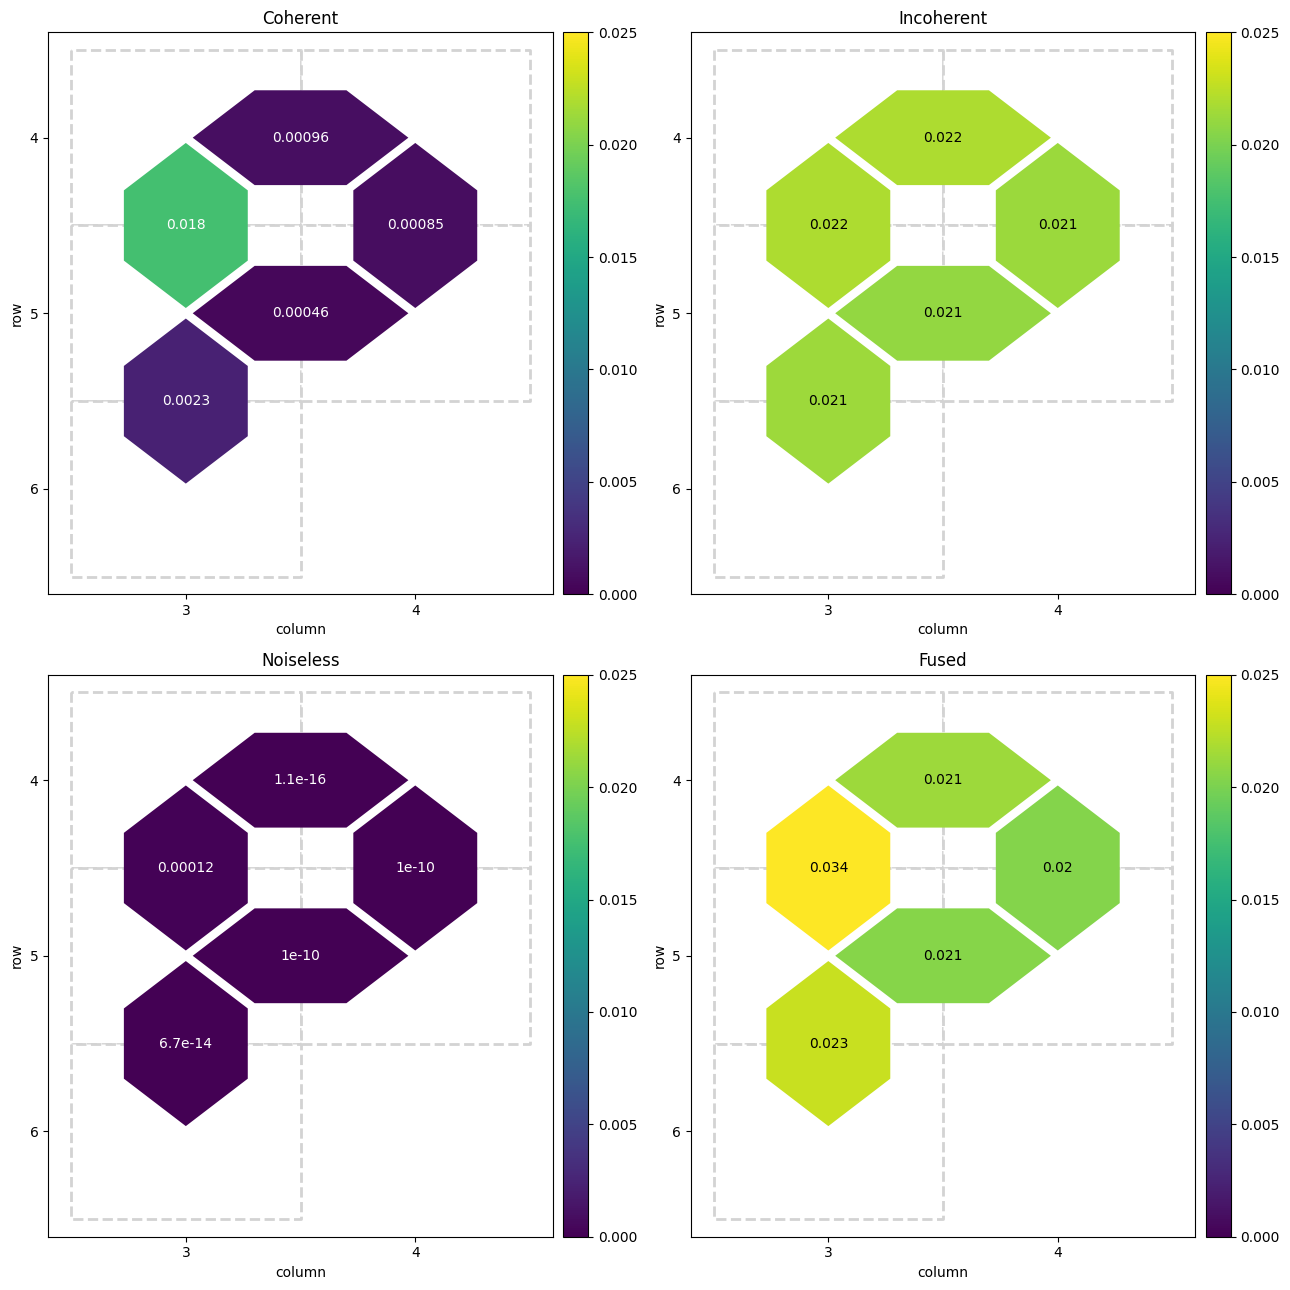

In [13]:
import matplotlib.pyplot as plt

fig, axes = plt.subplots(2, 2, figsize=(13, 13))
for fidelities, ax, title in zip(fitted_fidelities, axes.flat, noise_titles):
    # pull out the by-layer/cycle fidelity and turn it into error with 1-fidelity.
    heatmap_data = {
        pair: (1.0 - layer_fid) for ((_, _, pair), layer_fid) in fidelities.layer_fid.items()
    }
    cirq.TwoQubitInteractionHeatmap(heatmap_data, vmin=0, vmax=0.025).plot(ax)

    ax.set_title(title)

fig.tight_layout()
fig.show()

The heatmaps reveal that the estimated error is quite similar when compared across qubits in the mock device. 

The coherent error heatmap shows the most variation in qubit pair fidelity error, though all values are within `0.003` of each other. The perturbed `SQRT_ISWAP` gate produces a consistent change in angle that interacts differently with the random single-qubit rotations added in the two-qubit circuits of the `circuit_library`, causing this variance.

The incoherent error heatmap shows little to no variation in error. This makes sense because incoherent depolarization error randomly depolarizes in all basis angles at approximately the same rate, meaning consistent error in all cases. Note here that the overall error introduced by the incoherent noise model is much larger than the error introduced by the coherent noise model.  

The errorless case, as expected, has effectively zero error for all qubit pairs, The tiny error seen is caused by rounding errors during simulation.

The fused case shows both the relatively higher error from the incoherent error case, and the higher variance from the coherent error case. Across all qubits, this case produces the highest error seen yet, which makes sense given that both error models are in use simultaneously. 

### Circuit Fidelity by Cycle
The qubit pair heatmaps are good, but summarize the fidelity data too much to reveal meaningful patterns. To rectify this, graph the circuit fidelity by cycle, alongside an exponential decay curve from the by-cycle fidelity estimation. For reference, an exponential decay associated with the original depolarization chance of `5e-3` is included. 

First some graphing utilities:


In [14]:
import seaborn as sns

# map colors to qubit pairs
colors = sns.cubehelix_palette(n_colors=graph.number_of_edges())
colors = dict(zip(graph.edges, colors))


def _p_gen(ax, rescale=False, decay=5e-3, color=None, colors=colors, label=None):
    """Create a _p function to graph circuit fidelities by layer.
    It encodes the visualization options:
    - rescale: rescale data under the exponential decay line to range [0,1].
    - decay: exponent defining the exponential decay reference line.
    - color: plot everything in given color, use by-qubit color map otherwise.
    - colors: the by-qubit color map.
    - label: label to give the data in the legend.
    """

    def _p(record):
        """For a row of a fidelity data frame, plot based on encoded options"""

        # pull fidelities from data frame row/record
        data = record.fidelities

        # plot horizontal at 1.0 fidelity
        ax.axhline(1, color='grey', ls='--')

        # compute exponential decay line from record parameters (a, layer_fid)
        # these were computed by previous fitting from fidelity data
        xx = np.linspace(0, record.cycle_depths.max())
        exp = xeb_fitting.exponential_decay(xx, a=record.a, layer_fid=record.layer_fid)

        # rescale data to expand area under exponential reference decay line
        # the range from zero to the reference line becomes the range [0, 1]
        # also plot that reference line in blue, which, once rescaled, is horizontal
        if rescale:
            data = data / ((1 - decay) ** (4 * record.cycle_depths))
            exp = exp / ((1 - decay) ** (4 * xx))
            ax.plot(xx, xx**0, label=r'Normalized Reference', color='blue')
        else:
            ax.plot(xx, (1 - decay) ** (4 * xx), label=r'Exponential Reference', color='blue')

        _, _, pair = record.name
        q0, q1 = pair
        # use qubit pair to color map if color is not supplied, else just use color
        plot_color = colors[pair] if color is None else color
        # use qubit pair as label if not supplied, else just use label
        plot_label = f'{q0}-{q1}' if label is None else label

        # plot the data with the selected color and label
        ax.plot(record.cycle_depths, data, 'o-', color=plot_color, label=plot_label)
        # also plot the data-fitted exponential line
        ax.plot(xx, exp, color=plot_color, alpha=0.3)

    return _p


def extras(ax, title):
    """Add labels, title and legend to an axis"""

    ax.set_ylabel('Circuit fidelity')
    ax.set_xlabel('Cycle Depth $d$')
    ax.set_title(title)
    # create a legend while making sure the handles are unique
    handles, labels = ax.get_legend_handles_labels()
    legend_items = dict(zip(labels, handles))
    ax.legend(legend_items.values(), legend_items.keys(), loc='best')

Then use them to graph the different datasets.

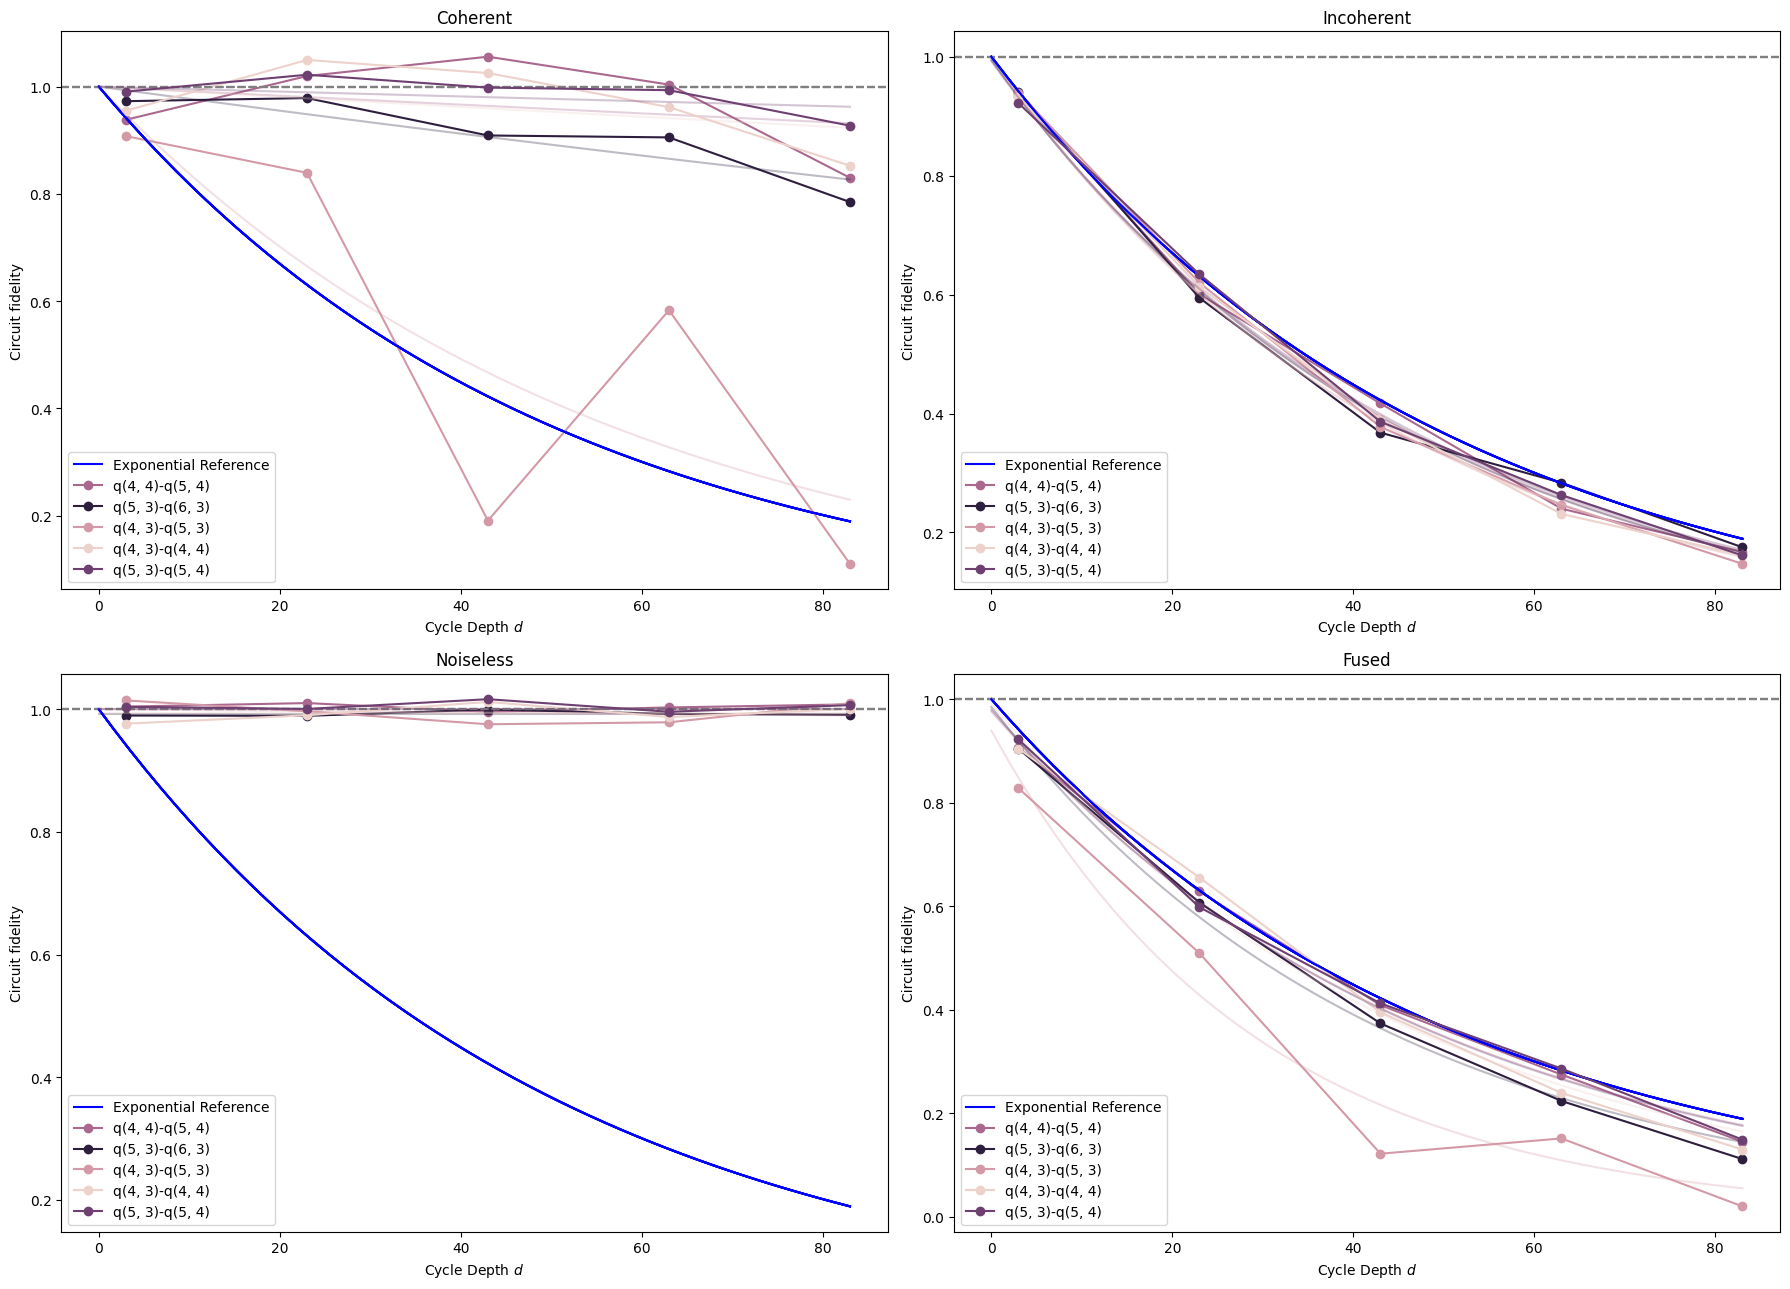

In [15]:
fig, axes = plt.subplots(2, 2, figsize=(18, 13))
for fidelities, ax, title in zip(fitted_fidelities, axes.flat, noise_titles):
    fidelities.apply(_p_gen(ax), axis=1)
    extras(ax, title)

fig.tight_layout()
fig.show()

The first, coherent error case, once again demonstrates the significant variance in circuit fidelity across the different qubits. This time it also shows that the variance between qubits can itself vary with the number of cycles that have been executed, which wasn't visible in the per-cycle estimation from the heatmaps. Additionally, individual exponential decay curves are fit and shown faded out for each qubit. The data only loosely fits an exponential decay, so using an exponential decay to model this type of coherent gate perturbation error may be imprecise. 

For the incoherent depolarization noise data, very little variance is seen between qubits, and all of them very closely match the reference curve. This empirically reinforces the expectation that a pauli depolarization noise model produces an exponential decay in the overall circuit fidelity. 

Unsurprisingly, the noiseless data produces no decrease in fidelity. 

In the fused case, both coherent perturbation and incoherent depolarization error contribute to the lowest circuit fidelity out of all cases. The overall fidelity is noticeably worse than the exponential reference and the incoherent data, as if they've been added together. It shows meaningfully more variance between qubits than the incoherent data, and this variation somewhat follows the pattern seen in the coherent data, with more variance around cycles 40 and 80, and less near cycles 20 and 60. However, it's somewhat hard to see this pattern given that the data is squashed into the space below the exponential reference curve.

In the following plot, the fused data is shown, rescaled under the expected incoherent error's `5e-3` exponential decay, alongside the original coherent data. 

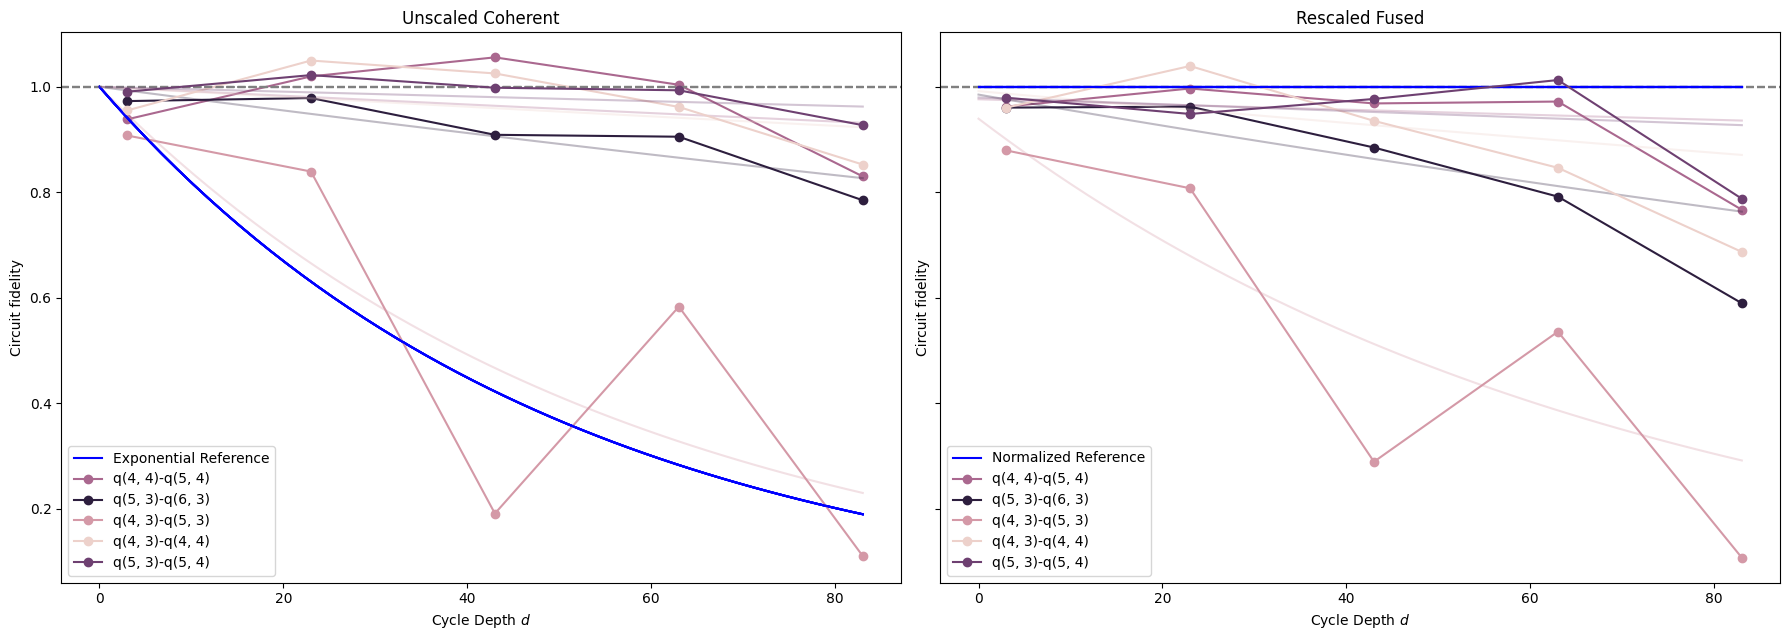

In [16]:
fig, axes = plt.subplots(1, 2, figsize=(18, 6.5), sharey=True)
two_fidelities = [fitted_fidelities[0], fitted_fidelities[3]]
titles = [r'Unscaled Coherent', r'Rescaled Fused']
for fidelities, rescale, ax, title in zip(two_fidelities, [False, True], axes.flat, titles):
    fidelities.apply(_p_gen(ax, rescale=rescale), axis=1)
    extras(ax, title)

fig.tight_layout()
fig.show()

The two graphs are almost identical, with the rescaled fused data demonstrating the same patterns of by-qubit and by-cycle variation as the coherent-only data. It seems that the rescaling has approximately eliminated the influence of the incoherent depolarization error portion from the fused error, leaving only the coherent perturbation error. 

However, the two graphs are not exactly identical; there are small differences in the measured fidelities. Remember, both of these datasets were generated with identical circuits, random seeds, and other parameters. The noiseless fidelities plot from before demonstrated that rounding errors produce extremely small variances in fidelities. Even scaled up, it seems as though rounding errors are not sufficient to explain the difference between the coherent and rescaled-fused data. Instead, it is likely that the incoherent and coherent error included in the fused fidelity data are not entirely independent of one another in these benchmarking circuits. They likely interact nontrivially, producing some overlapping or unique error cases that would be found by, respectively, both or neither error model in isolation. 

## Characterize Gate Parameters

A classical optimizer can be used to approximate the two-qubit gate parameters that were actually used from the fidelity data. Here, the parameter of interest is the `phi` parameter, which is the one used to perturb `SQRT_ISWAP`. To characterize `phi`, flag it in the `SqrtISwapXEBOptions` object. Don't characterize the others parameters, for runtime reasons. This object, once passed into the optimizer wrapper `characterize_phased_fsim_parameters_with_xeb_by_pair`, denotes that the optimizer expects the two-qubit entangling gate used to be a `SQRT_ISWAP`, and that it will look for parameters to that gate (or the PhasedFSim version of it) which most closely replicate the observed fidelity data. 

In a real experiment, there are certainly additional kinds of coherent error. The following optimization procedure attempts to identify coherent error that produces a consistent change in the parameters of the circuits' two-qubit entangling gate, assuming it is in the `PhasedFSim` family. Other types of error, coherent and otherwise, may confound this process. 

In [17]:
import multiprocessing

pool = multiprocessing.get_context('spawn').Pool()

In [18]:
# Set which angles to characterize (all)
options = xeb_fitting.SqrtISwapXEBOptions(
    characterize_theta=False,
    characterize_zeta=False,
    characterize_chi=False,
    characterize_gamma=False,
    characterize_phi=True,
)
# Parameterize the sqrt(iswap)s in circuit library
pcircuits = [xeb_fitting.parameterize_circuit(circuit, options) for circuit in circuit_library]


def characterization_result(sampled_df):
    # Run the characterization loop
    return xeb_fitting.characterize_phased_fsim_parameters_with_xeb_by_pair(
        sampled_df,
        pcircuits,
        cycle_depths,
        options,
        pool=pool,
        # ease tolerance so it converges faster:
        fatol=1e-2,
        xatol=1e-2,
    )

Perform the coherent error characterization on the sample data, across all used noise models.

Note: This cell will take 8 or so minutes to run on a default Google Colab instance. 

In [19]:
%%time
characterization_results = list(map(characterization_result, sampled_dfs))

CPU times: user 677 ms, sys: 23 ms, total: 700 ms
Wall time: 1min 30s


Inspect the characterized parameters estimated for the coherent-only perturbation noise model. Note that, across all qubits, the characterization for the first, coherent error case, has correctly estimated the `phi` parameter to be in the range $[0, 2/16*\pi] = [0, 0.393]$, or very close to it.

In [20]:
characterization_results[0].final_params

{(cirq.GridQubit(4, 3), cirq.GridQubit(5, 3)): {'phi': 0.41875000000000007},
 (cirq.GridQubit(4, 4), cirq.GridQubit(5, 4)): {'phi': 0.10625000000000001},
 (cirq.GridQubit(5, 3), cirq.GridQubit(6, 3)): {'phi': 0.13125},
 (cirq.GridQubit(5, 3), cirq.GridQubit(5, 4)): {'phi': 0.1},
 (cirq.GridQubit(4, 3), cirq.GridQubit(4, 4)): {'phi': 0.06875}}

By additionally inspecting the original `phi_angles` used to add noise, you can see that the characterization was able to correctly estimate each qubit's individual phi value within about $\pm 0.04$ error.

In [21]:
for qubits, phi in phi_angles.items():
    print(qubits, phi)

(cirq.GridQubit(4, 3), cirq.GridQubit(5, 3)) 0.3799064806542888
(cirq.GridQubit(4, 4), cirq.GridQubit(5, 4)) 0.08119129771673056
(cirq.GridQubit(5, 3), cirq.GridQubit(6, 3)) 0.14120271164445705
(cirq.GridQubit(5, 3), cirq.GridQubit(5, 4)) 0.06671132621887749
(cirq.GridQubit(4, 3), cirq.GridQubit(4, 4)) 0.09041395290935288


## Visualizing Refitted Fidelities by Noise Model

Finally, plot the original and refit circuit fidelities by cycle, with exponential decay curves, for each of the available datasets. 

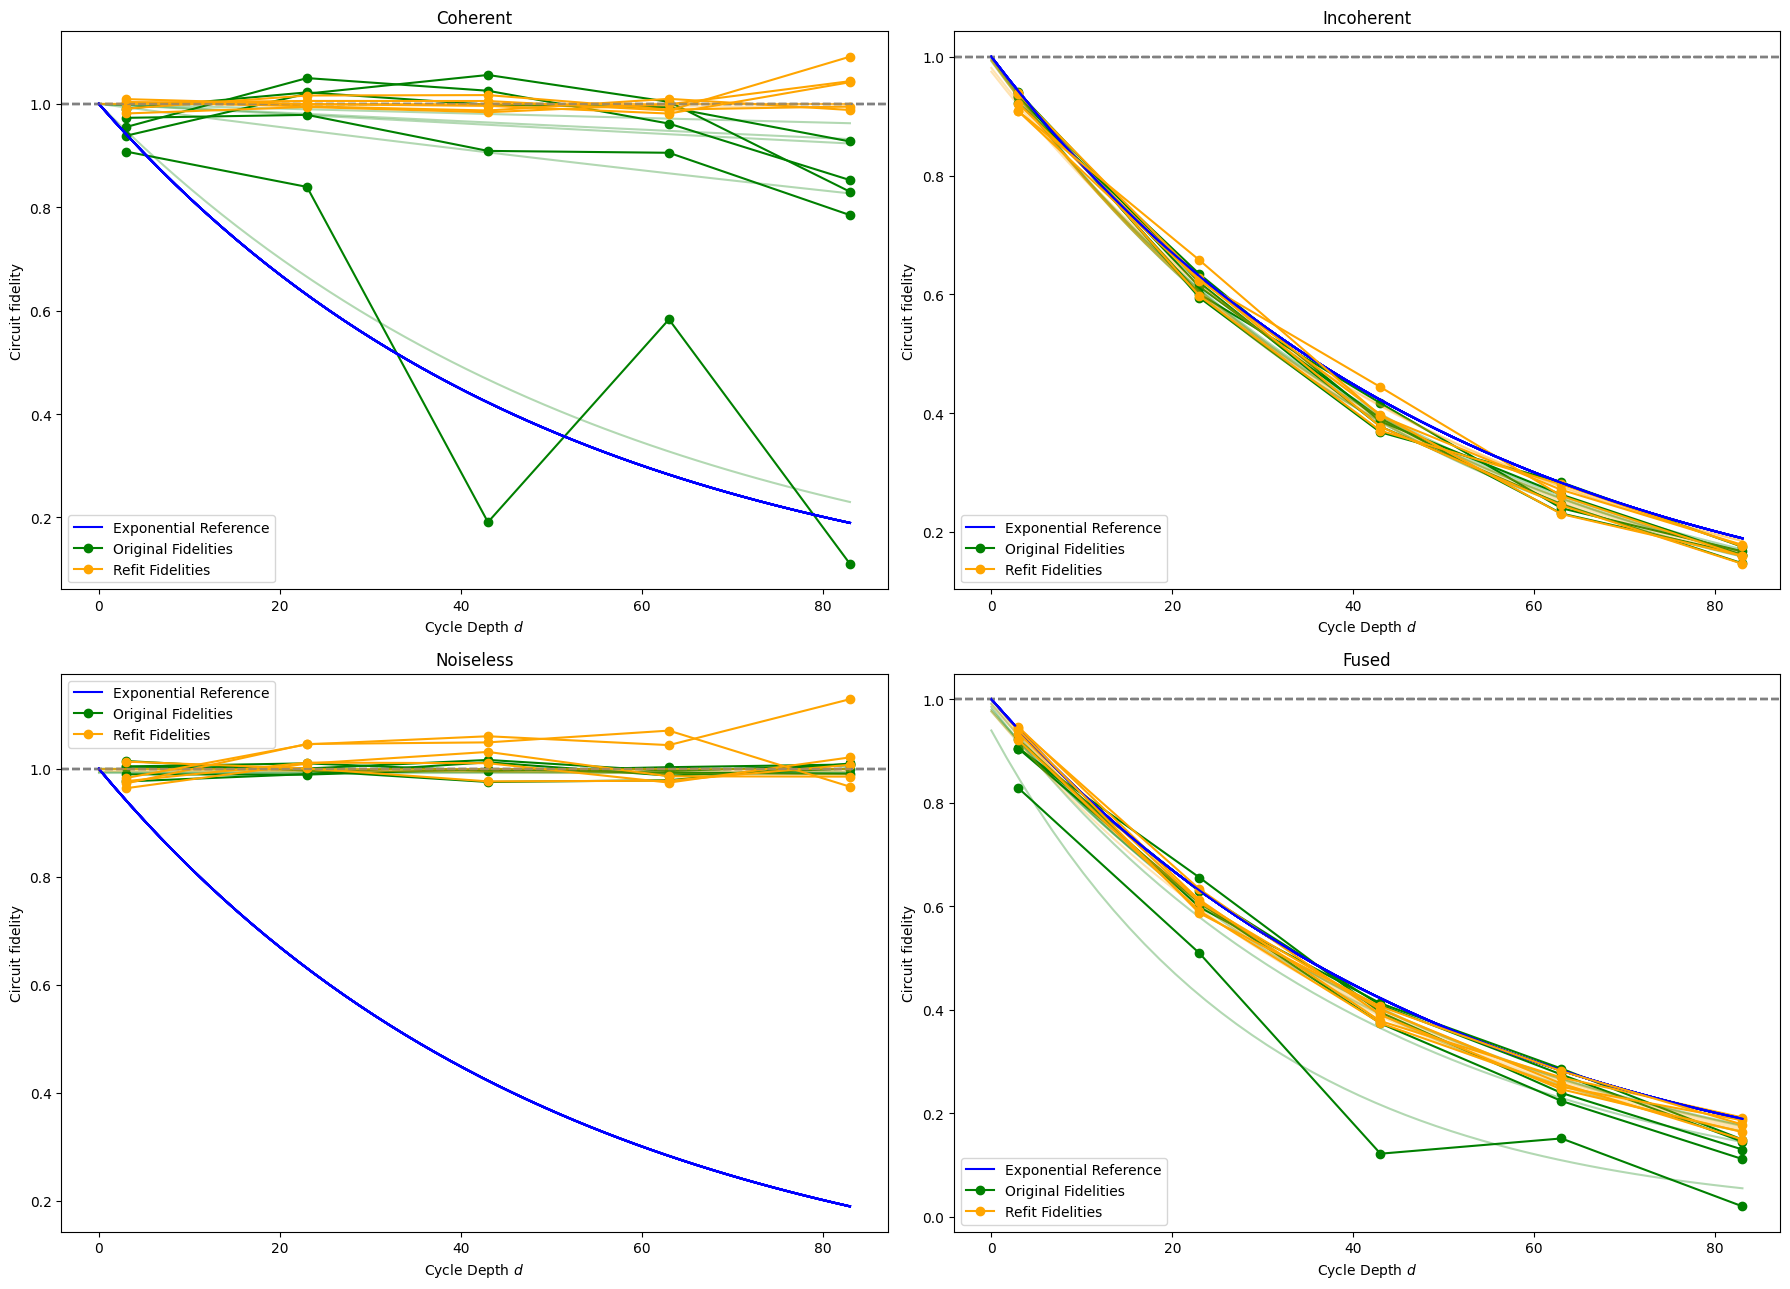

In [22]:
fig, axes = plt.subplots(2, 2, figsize=(18, 13))
result_dfs = list(map(lambda x: x.fidelities_df, characterization_results))
result_fidelities = list(map(xeb_fitting.fit_exponential_decays, result_dfs))
before_dfs = fitted_fidelities
after_dfs = result_fidelities
for before_df, after_df, ax, title in zip(before_dfs, after_dfs, axes.flat, noise_titles):
    before_df.apply(_p_gen(ax, color='green', label=r'Original Fidelities'), axis=1)
    after_df.apply(_p_gen(ax, color='orange', label=r'Refit Fidelities'), axis=1)
    extras(ax, title)

fig.tight_layout()
fig.show()

In the coherent error case, the optimization was able to refit the fidelities very well. The new curves of the refit data almost perfectly match the horizontal line at `1.0` fidelity. The success of this refit means that the estimated parameters for this case are very likely to represent the actual parameters of the gate operation used, which was seen in the fact that the optimization re-discovered the `phi` value that was originally used to perturb `SQRT_ISWAP`. In the real hardware case, identifying these parameters means identifying what unitary the gate control hardware actually implemented. If this unitary is far from the intended one, hardware re-calibration or [compensation](../calibration_api.ipynb) must be performed in order to improve circuit fidelity. 

In constrast, the optimizer was completely unable to refit the circuit fidelities in the incoherent error case. The refit fidelities find no meaningful fidelity improvement, instead following the same, expected `5e-3` exponential decay as the original fidelities. Unsurprisingly, the optimizer was unable to find any coherent error in the incoherent-only fidelity data. 

The noiseless case also fails, but in a different way. Due to the fact that all of the original fidelities are extremely close to `1.0`, the optimization likely overvalues the miniscule differences in rounding error and overfits its model. 

The fused error case produces refit fidelities that are noticeably improved over the original ones, but only reach up to the exponential reference curve. It seems as though the optimization was able to detect and refit for the coherent error, but not the incoherent error. This means this parameter fitting procedure is still able to find improvements when multiple types of error are present. However, the fused graph again compacts all of the data under the exponential reference curve. The next cell performs the same rescaling as before to inspect the coherent error present in the fused data. 

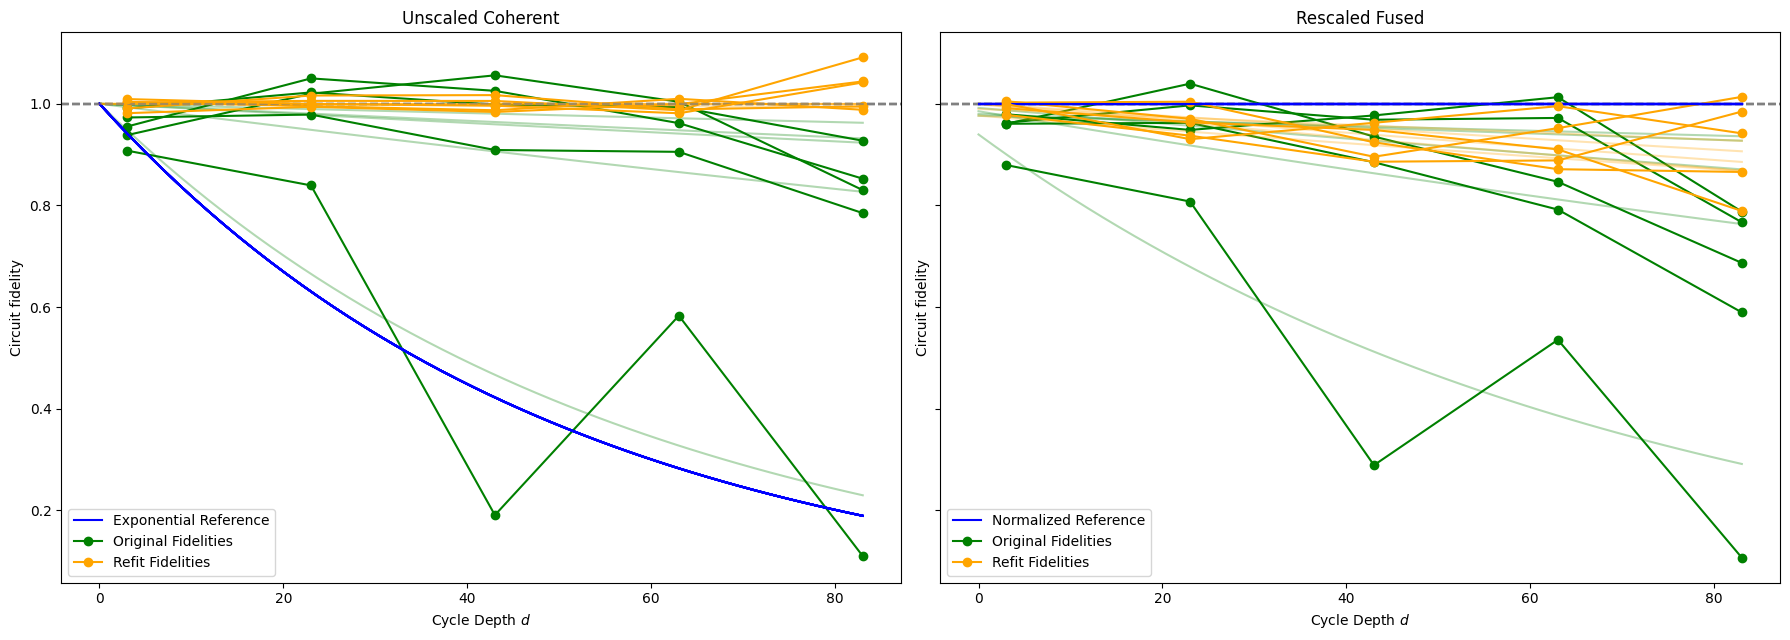

In [23]:
fig, axes = plt.subplots(1, 2, figsize=(18, 6.5), sharey=True)
before_dfs = [fitted_fidelities[0], fitted_fidelities[3]]
after_dfs = [result_fidelities[0], result_fidelities[3]]
titles = [r'Unscaled Coherent', r'Rescaled Fused']
for before_df, after_df, ax, title, rescale in zip(
    before_dfs, after_dfs, axes.flat, titles, [False, True]
):
    before_df.apply(
        _p_gen(ax, color='green', label=r'Original Fidelities', rescale=rescale), axis=1
    )
    after_df.apply(_p_gen(ax, color='orange', label=r'Refit Fidelities', rescale=rescale), axis=1)
    extras(ax, title)

fig.tight_layout()
fig.show()

As noted, the optimizer is able to nearly perfectly refit the fidelities in the unscaled coherent error case. 

Rescaling the fused error data provides a similar result in the refit fidelities as in the original ones. The optimizer was unable to produce refit data with curves that follow the constant `1.0` line (which is the `5e-3` exponential decay curve when unscaled). Instead, the variety of orange refit curves around the blue reference line indicate that the presence of the incoherent error acts as a confounding variable to the optimizer, reducing its effectiveness noticeably. 

However, it still performed quite well overall, finding refit fidelities that are significantly better than the original ones. Additionally, the patterns of variance between qubits are similar between the refit fidelities of the coherent and rescaled data. This may imply that the optimizer is finding similar patterns of coherent error in the fused data as in the coherent-only data. Finally, the optimizer was able to identify the coherent error, even though the incoherent error was roughly an order of magnitude larger. 

## Conclusion

Cross Entropy Benchmarking and optimizer refitting has been shown here to effectively characterize patterns of coherent error, to find the (parameters of the) true unitary operation used on individual qubit pairs. Importantly, this is effective even in the case where incoherent error is also acting on the system, but with noticeably reduced accuracy. In a real hardware system, with many interacting sources of error, XEB can still be useful to identify consistent coherent error, but it's important to remember that other error can confound these results. 

## What's Next?

Now that you've identified coherent error, what can you do about it? 
- Depending on the parameter(s) identified to be out of tune, you may be able to change the circuits you want to run to compensate for that change. Read [Calibration API](../calibration_api.ipynb) for further information.
- In the real hardware case, the device may need to be re-calibrated in order to fix the tuning of particular gate operations on particular qubits. Reach out to your google contact to let us know!